# Deep Symbolic Learning
Ruchi Gupte

In [2]:
import numpy as np
from numpy import asarray,save,load
from numpy.lib.stride_tricks import as_strided
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import MeanShift
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import NearestCentroid
import idx2numpy
import pickle
from PIL import Image
import cv2
import json
import math
import glob
import random
import sklearn
import time

In [3]:
config = {'training_image_path'            : "Jio_imagepath/train-images.idx3-ubyte", 
           'test_image_path'               : "Jio_imagepath/t10k-images.idx3-ubyte",
           'genral_path_incase_of_folder'  : 'Jio_imagepath/New',
           'dataset_format'                : "ubyte",
           'sampleimages'                  : 1000,
           'window_size'                   : 5,
           'Stride'                        : 3,
           'padding'                       : [0,1,0,1],
           'image_size'                    : 28,
           'clustering_model'              : 'KMEANS',
           'n_clusters'                    : 75,
           'bandwidth'                     : 300,
           'test_skip'                     : 2,
           'Consistency_formula'           : 'NPMI'
          }

with open('config.json', 'w') as f:
        json.dump(config, f)

# Stage 0 : Read Stage
Taking input as config.json file, take test images and load them and store them

In [4]:
#INPUT----------------------------------
with open('config.json', 'r') as f:
        config = json.load(f)
padding=config['padding']
no_of_sampleimages=config['sampleimages']
type_dataset=config['dataset_format']
#INPUT----------------------------------

In [6]:
if type_dataset=='folder':
    final_image_list = []
    for img in glob.glob(config['genral_path_incase_of_folder']+'/*.jpg*'):
        temp_image= cv2.imread(img,0)
        final_image_list.append(temp_image)
    random.shuffle(final_image_list)
    testdata, traindata = sklearn.model_selection.train_test_split(final_image_list, train_size=0.4, test_size=0.6)

elif type_dataset=='ubyte':
    traindata = idx2numpy.convert_from_file(config['training_image_path']) 
    testdata = idx2numpy.convert_from_file(config['test_image_path']) 

else:
    print("Error")

In [7]:
traindata = traindata[:no_of_sampleimages]
testdata = testdata[:no_of_sampleimages]

In [8]:
final_train_data=[0]*no_of_sampleimages
for k in range(no_of_sampleimages):
    final_train_data[k]=np.pad(traindata[k], [(padding[0], padding[1]), (padding[2], padding[3])], mode='constant', constant_values=0)
    
final_test_data=[0]*no_of_sampleimages
for k in range(no_of_sampleimages):
    final_test_data[k]=np.pad(traindata[k], [(padding[0], padding[1]), (padding[2], padding[3])], mode='constant', constant_values=0)

In [9]:
#OUTPUT-------------------------------------------
save('Array_of_training_images1.npy', final_train_data)
save('Array_of_test_images1.npy', final_test_data)
#OUTPUT-------------------------------------------

# Stage 1 :Low Level Feature extraction
Taking input as config.json and training data, convert data into patches and store them and store them

In [10]:
#INPUT----------------------------------
with open('config.json', 'r') as f:
        config = json.load(f)
data = load('Array_of_training_images1.npy')
#INPUT----------------------------------

In [11]:
widthi=heighti=config['image_size']
no_of_sampleimages=config['sampleimages']
patch_size=config['window_size']
shift=config['Stride']
padding=config['padding']

In [12]:
X_im=[]
for k in range(no_of_sampleimages):
    patchl=0
    patchh=0
    image=data[k]
    for i in range(0,heighti+padding[0]+padding[1]-(patch_size-1),shift):
        for j in range(0,widthi+padding[2]+padding[3]-(patch_size-1),shift):
            BLOCK=image[i:i+patch_size,j:j+patch_size]
            X_im.append(BLOCK) 
            patchl=patchl+1
        patchh=patchh+1
        
patchl=int(patchl/patchh)
X_im = np.array(X_im)

In [13]:
#OUTPUT-------------------------------------------
config.update( {'patchl' : patchl, #patch length
                'patchh' : patchh} ) #patch height
with open('config.json', 'w') as f:
        json.dump(config, f)
save('patchlist1.npy', X_im)
#OUTPUT-------------------------------------------

# Stage 2: Symbolic ID Creation
Taking input as config.json and data of image patches, perform clustering on them and gather data like centroids, distances and assign each patch to a appropriate cluster.

In [14]:
#INPUT----------------------------------
patchlist = load('patchlist1.npy')
with open('config.json', 'r') as f:
        config = json.load(f)
#INPUT---------------------------------

In [15]:
patch_size=config['window_size']

In [16]:
if config['clustering_model']=='KMEANS':
    time_start = time.time()
    n_clusters=config['n_clusters']
    model = KMeans(n_clusters=n_clusters, n_init=10, max_iter=300, tol=1e-4, verbose=0, random_state=None, copy_x=True, algorithm="auto")
    model=model.fit(patchlist.reshape(len(patchlist),-1))
    labels=model.labels_
    centroids = model.cluster_centers_
    print("Kmeans Done. Time elapsed: {} minutes".format((time.time()-time_start)/60))
    print(time.time()-time_start)

elif config['clustering_model']=='MEANSHIFT':
    time_start = time.time()
    bandwidth=config['bandwidth']
    model = MeanShift(bandwidth=bandwidth, bin_seeding=False, cluster_all=True, min_bin_freq=1, n_jobs=1, seeds= None)
    model=model.fit(patchlist.reshape(len(patchlist),-1))
    labels = model.labels_
    centroids = model.cluster_centers_
    labels_unique = np.unique(labels)
    n_clusters = len(labels_unique)
    config.update( {'n_clusters' : n_clusters} )
    print ("MeanShift Done. Time elapsed: {} minutes".format((time.time()-time_start)/60))

Kmeans Done. Time elapsed: 1.2061927596728006 minutes
72.37156558036804


In [17]:
model.get_params() 

{'algorithm': 'auto',
 'copy_x': True,
 'init': 'k-means++',
 'max_iter': 300,
 'n_clusters': 75,
 'n_init': 10,
 'n_jobs': 'deprecated',
 'precompute_distances': 'deprecated',
 'random_state': None,
 'tol': 0.0001,
 'verbose': 0}

In [18]:
def Sort(sub_li): 
    sub_li.sort(key = lambda x: x[1]) 
    return sub_li 

In [19]:
k=0
clusterdata=[]
for clus in range(n_clusters):
    for i in patchlist[np.where(labels==clus)]:
        k=k+1
    temp=[clus+1,k]
    clusterdata.append(temp)   
    k=0 #comment to check cumulative density 
clusterdata=Sort(clusterdata)

In [20]:
#for i in range(n_clusters, 0, -1):
    #print(clusterdata[i-1][0],'   :  ', clusterdata[i-1][1])

In [21]:
temp=[]
clustack=[]
for clus in range(n_clusters):
    for i in patchlist[np.where(labels==clus)]:
        temp.append(i)
    clustack.append(np.array(temp))
    temp=[]
clustack=np.array(clustack)

In [22]:
dist=[]
for Clusterno in range(n_clusters):
    temp=[]
    Cent=centroids[Clusterno].reshape(patch_size,patch_size)
    k=0
    for m in clustack[Clusterno]:
        distance = np.linalg.norm(m-Cent)
        distance=[int(k),int(distance)]
        temp.append(distance)
        k=k+1
    dist.append(temp)
for clus in range(n_clusters):
    dist[clus]=np.array(Sort(dist[clus]))

In [23]:
Rows=10  #how many rows and columns in collage
Columns=10

#Making Collage
cluster_no=4 # cluster number
Background_white = [255,255,255]
final_collage = Image.new('RGBA', (1000, 1000), (255, 255,255))
k=0

for i in range(0,Columns*100,100):
    for j in range(0,Rows*100,100):
        temp_image=cv2.copyMakeBorder(clustack[cluster_no-1][int(dist[cluster_no-1][k][0])],0,1,0,1,cv2.BORDER_CONSTANT,value=Background_white)
        temp_image = Image.fromarray(temp_image, 'L')
        temp_image = temp_image.resize((100,100), resample=Image.NEAREST)
        k=k+1
        final_collage.paste(temp_image, (j,i))

final_collage.show()

In [24]:
#OUTPUT------------------------------------------------- Remove 2 for orignal
save('cluster_density1.npy', clusterdata)
save('patch_with_clusters1.npy', clustack)
save('distance_info_for_clusters1.npy', dist)
pickle.dump(model, open('model1.sav', 'wb'))
#OUTPUT-------------------------------------------------

In [25]:
pickle.dump(model, open('model1.sav', 'wb'))

# Stage 3 : Symbolic ID Assignment
Taking input as config.json, model, its parameters, and test data, convert them to a symbolic matrix using the model from the training images.

In [26]:
#INPUT----------------------------------------------------
with open('config.json', 'r') as f:
        config = json.load(f)
model = pickle.load(open('model1.sav', 'rb'))
test_data=load('Array_of_test_images1.npy',allow_pickle = True )
#INPUT-----------------------------------------------------

In [27]:
labels=model.labels_
centroids = model.cluster_centers_
n_clusters = config['n_clusters']
no_of_sampleimages=config['sampleimages']
widthi=heighti=config['image_size']
padding=config['padding']
patch_size=config['window_size']
shift=config['Stride']
patchl=config['patchl']
patchh=config['patchh']

In [334]:
#assigning symbolic ID for all test patches
test_symboliclist=[]
time_start = time.time()
for testno in range(no_of_sampleimages):
    X_reconstructed=[]
    image=test_data[testno]  #to select an image number
    for i in range(0,heighti+padding[0]+padding[1]-(patch_size-1),shift):
        for j in range(0,widthi+padding[2]+padding[3]-(patch_size-1),shift):
            BLOCK=image[i:i+patch_size,j:j+patch_size]
            v=model.predict(BLOCK.reshape(1, -1))
            X_reconstructed.append(v[0]+1)
    test_symboliclist.append(X_reconstructed)
print("Symbolic List Created. Time elapsed: {} minutes".format((time.time()-time_start)/60))

Symbolic List Created. Time elapsed: 53.71212753454844 minutes


In [144]:
for testno in range(no_of_sampleimages):
    test_symboliclist[testno]=np.array(test_symboliclist[testno])
    test_symboliclist[testno]=test_symboliclist[testno].reshape(patchl,patchh)

In [8]:
test_symboliclist[1]

array([[ 2,  2,  2,  2, 48, 35, 56,  2,  2],
       [ 2,  2,  2, 48,  3, 17, 50, 56,  2],
       [ 2,  2, 48,  3, 65, 16, 28, 20,  2],
       [ 2,  2,  3, 32, 75, 34, 51, 50,  2],
       [ 2,  6,  8, 73,  2, 48, 51, 68,  2],
       [ 2, 44, 42, 59, 48,  3, 32, 54,  2],
       [ 2, 44, 28, 60, 67, 69, 54,  2,  2],
       [ 2, 43, 23, 26, 64, 59,  2,  2,  2],
       [ 2,  2,  2,  2,  2,  2,  2,  2,  2]])

In [9]:
X_reconstructed=test_symboliclist[999].reshape(patchl*patchh,)
#X_reconstructed=test_images[1].reshape(patchl*patchh,)
Background_white = [255,255,255]

final_image = Image.new('RGBA', (1000, 1000), (255, 255, 255, 255))

k=0
for i in range(0,patchh*100,100):
    for j in range(0,patchl*100,100):
        Centroid=centroids[X_reconstructed[k]-1].reshape(patch_size,patch_size)
        temp_image=cv2.copyMakeBorder(Centroid,0,1,0,1,cv2.BORDER_CONSTANT,value=Background_white)
        temp_image = Image.fromarray(temp_image)
        temp_image = temp_image.resize((100,100), resample=Image.NEAREST)
        k=k+1
        final_image.paste(temp_image, (j,i))
               
final_image.show()

In [154]:
#OUTPUT-------------------------------------------------Remove 2 for orignal
save('testdata_symboliclist1.npy', test_symboliclist)
#OUTPUT-------------------------------------------------

In [7]:
test_symboliclist=load('testdata_symboliclist1.npy')

# Stage 4: Hardcoding directional matrix
Since the position of matrix elements remains same across same size images, obtain directional matrix values of each element wrt all other elements in that matrix. Input as config.json.

In [169]:
#INPUT-----------------------------------------
with open('config.json', 'r') as f:
        config = json.load(f)
no_of_sampleimages=config['sampleimages']
test_skip=config["test_skip"]
symbolic_list=load('testdata_symboliclist1.npy')
patch_size=config['window_size']
#INPUT-----------------------------------------

In [170]:
patchlength=config['patchl']
patchheight=config['patchh']

In [171]:
def cos2(x): 
    ans=math.cos(x)*math.cos(x)
    return ans

def sin2(x): 
    ans=math.sin(x)*math.sin(x)
    return ans

def sliding_window(arr, window_size):
    """ Construct a sliding window view of the array"""
    arr = np.asarray(arr)
    window_size = int(window_size)
    if arr.ndim != 2:
        raise ValueError("need 2-D input")
    if not (window_size > 0):
        raise ValueError("need a positive window size")
    shape = (arr.shape[0] - window_size + 1,
             arr.shape[1] - window_size + 1,
             window_size, window_size)
    if shape[0] <= 0:
        shape = (1, shape[1], arr.shape[0], shape[3])
    if shape[1] <= 0:
        shape = (shape[0], 1, shape[2], arr.shape[1])
    strides = (arr.shape[1]*arr.itemsize, arr.itemsize,
               arr.shape[1]*arr.itemsize, arr.itemsize)
    return as_strided(arr, shape=shape, strides=strides)

def cell_neighbors(arr, i, j, d):
    """Return d-th neighbors of cell (i, j)"""
    w = sliding_window(arr, 2*d+1)

    ix = np.clip(i - d, 0, w.shape[0]-1)
    jx = np.clip(j - d, 0, w.shape[1]-1)

    i0 = max(0, i - d - ix)
    j0 = max(0, j - d - jx)
    i1 = w.shape[2] - max(0, d - i + ix)
    j1 = w.shape[3] - max(0, d - j + jx)

    return w[ix, jx][i0:i1,j0:j1].ravel()

In [172]:
symbolic_list[1]

array([[ 2,  2,  2,  2, 48, 35, 56,  2,  2],
       [ 2,  2,  2, 48,  3, 17, 50, 56,  2],
       [ 2,  2, 48,  3, 65, 16, 28, 20,  2],
       [ 2,  2,  3, 32, 75, 34, 51, 50,  2],
       [ 2,  6,  8, 73,  2, 48, 51, 68,  2],
       [ 2, 44, 42, 59, 48,  3, 32, 54,  2],
       [ 2, 44, 28, 60, 67, 69, 54,  2,  2],
       [ 2, 43, 23, 26, 64, 59,  2,  2,  2],
       [ 2,  2,  2,  2,  2,  2,  2,  2,  2]])

In [173]:
test_images=[]
image=[]
for num in range(no_of_sampleimages):
    image=symbolic_list[num]
    patchl=0
    patchh=0
    temp=[]
    for i in range(0,patchheight,test_skip):
        for j in range(0,patchlength,test_skip):
            temp.append(image[i][j])
            patchl=patchl+1
        patchh=patchh+1
    
    patchl=int(patchl/patchh)
    temp=np.array(temp)
    temp=temp.reshape(patchh,patchl)
    test_images.append(temp)
test_images[1]

array([[ 2,  2, 48, 56,  2],
       [ 2, 48, 65, 28,  2],
       [ 2,  8,  2, 51,  2],
       [ 2, 28, 67, 54,  2],
       [ 2,  2,  2,  2,  2]])

In [174]:
X_reconstructed=test_images[10].reshape(patchl*patchh,)
#X_reconstructed=test_images[1].reshape(patchl*patchh,)
Background_white = [255,255,255]

final_image = Image.new('RGBA', (1000, 1000), (255, 255, 255, 255))

k=0
for i in range(0,patchh*100,100):
    for j in range(0,patchl*100,100):
        Centroid=centroids[X_reconstructed[k]-1].reshape(patch_size,patch_size)
        temp_image=cv2.copyMakeBorder(Centroid,0,0,0,0,cv2.BORDER_CONSTANT,value=Background_white)
        temp_image = Image.fromarray(temp_image)
        temp_image = temp_image.resize((100,100), resample=Image.NEAREST)
        k=k+1
        final_image.paste(temp_image, (j,i))
               
final_image.show()

In [175]:
arrayorder=[]
k=0
for y2 in range(patchh):
    for x2 in range(patchl):
        arrayorder.append(k)
        k=k+1
arrayorder=np.array(arrayorder)
arrayorder=arrayorder.reshape(patchh,patchl)
arrayorder

array([[ 0,  1,  2,  3,  4],
       [ 5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14],
       [15, 16, 17, 18, 19],
       [20, 21, 22, 23, 24]])

In [176]:
#make patchh,patchl 5 if we change the dimension of input matrix
weights=[]
for y1 in range(patchh):
    for x1 in range(patchl):
        temp=[]
        for y2 in range(patchh):
            for x2 in range(patchl):
                if y2>y1 and x1==x2:
                    x=90 #pure north
                elif y2<y1 and x1==x2:
                    x=-90 #pure south
                elif y2==y1 and x2==x1:
                    x=0
                elif x1>x2 and y1==y2:
                    x=404   #pure west
                elif x2>x1 and y1==y2:
                    x=303  #pure east
                else:
                    slope = ((y2-y1)/(x2-x1))
                    x=math.atan(slope)
                temp.append([int(x1),int(y1),int(x2),int(y2),x])
        weights.append(temp)
#getting angles for each element[point1,point2==>angle]

In [177]:
values=[]
l=0
for y1 in range(patchh):
    for x1 in range(patchl):
        k=0
        element=[]
        for y2 in range(patchh):
            for x2 in range(patchl):
                angle=weights[l][k][4] #radians
                if angle==90:
                    ans=[1,0,0,0] #north
                elif angle==-90:
                    ans=[0,1,0,0] #south
                elif angle==404:
                    ans=[0,0,1,0] #east
                elif angle==303:
                    ans=[0,0,0,1] #west
                elif x1==x2 and y1==y2:
                    ans=[0,0,0,0] #samepoint       
                elif x1>x2 and y1>y2:
                    ans=[0,sin2(angle),0,cos2(angle)] #southwest
                elif x1>x2 and y1<y2:
                    ans=[sin2(angle),0,0,cos2(angle)] #northwest
                elif x1<x2 and y1>y2:
                    ans=[0,sin2(angle),cos2(angle),0] #southeast
                elif x1<x2 and y1<y2:
                    ans=[sin2(angle),0,cos2(angle),0] #northeast
                else:
                    ans=4040404 #error
                element.append([x1,y1,x2,y2,ans]) #all relations for one point
                k=k+1 #increment to next point
        #print(4040404 in element[4])
        values.append(element)  
        l=l+1 #increment to next pivot point

In [178]:
#values[5]#x1,y1,x2,y2,directionalmatrix for those 2 positions

In [179]:
neighbor_value=2
final=[]
c=0
for y1 in range(patchh):
    for x1 in range(patchl):
        ans=cell_neighbors(arrayorder,y1,x1,neighbor_value)\
        #ans=arrayorder.reshape(81,)
        #shape=int(math.sqrt(len(ans)))
        standby=[]
        for i in range(len(ans)):
            standby.append(values[c][ans[i]])
        final.append(standby) #final gives only those points within neighbor distance
        c=c+1

In [184]:
save("AllHardcoded_directionalmatrix1.npy", values)
save("New_symbolic_list1.npy", test_images)
save("Selected_Hardcoded_directionalmatrix1.npy", final)
config.update( {'stage4_patchl' : patchl,
                'stage4_patchh' : patchh} )
with open('config.json', 'w') as f:
        json.dump(config, f)

# Stage 5: Patch to Patch Co-Occurence

In [32]:
#INPUT-----------------------------------------
with open('config.json', 'r') as f:
        config = json.load(f)
new_symbolic_list=load('New_symbolic_list1.npy')
patchl=config['stage4_patchl']
patchh=config['stage4_patchh']
no_of_sampleimages=config['sampleimages']
values=load('AllHardcoded_directionalmatrix1.npy',allow_pickle = True )
final=load('Selected_Hardcoded_directionalmatrix1.npy',allow_pickle = True )
#INPUT-----------------------------------------

In [33]:
time_start = time.time()
north_table = []
south_table=[]
east_table=[]
west_table=[]
for num in range(1000):
    trial=new_symbolic_list[num]
    for poi in range(len(final)):
        for ele in range(len(final[poi])):
            data=final[poi][ele]
            a_id=trial[data[1]][data[0]]
            b_id=trial[data[3]][data[2]]
            dictionary_data_north = {'a_id': a_id, 'b_id' : b_id, 'count_north': data[4][0]}
            dictionary_data_south= {'a_id': a_id, 'b_id' : b_id, 'count_south': data[4][1]}
            dictionary_data_east= {'a_id': a_id, 'b_id' : b_id, 'count_east': data[4][2]}
            dictionary_data_west= {'a_id': a_id, 'b_id' : b_id, 'count_west': data[4][3]}          
            north_table.append(dictionary_data_north)
            south_table.append(dictionary_data_south)
            east_table.append(dictionary_data_east)
            west_table.append(dictionary_data_west)
                
north_table = pd.DataFrame.from_dict(north_table)
north_table = north_table[(north_table[['count_north']] != 0).all(axis=1)]
north_table = pd.pivot_table(north_table, values='count_north', index=['a_id', 'b_id'], aggfunc=np.sum)
north_table = north_table.sort_values(('count_north'), ascending=False)

south_table = pd.DataFrame.from_dict(south_table)
south_table = south_table[(south_table[['count_south']] != 0).all(axis=1)]
south_table = pd.pivot_table(south_table, values='count_south', index=['a_id', 'b_id'],aggfunc=np.sum)
south_table = south_table.sort_values(('count_south'), ascending=False)

east_table = pd.DataFrame.from_dict(east_table)
east_table = east_table[(east_table[['count_east']] != 0).all(axis=1)]
east_table = pd.pivot_table(east_table, values='count_east', index=['a_id', 'b_id'], aggfunc=np.sum)
east_table = east_table.sort_values(('count_east'), ascending=False)

west_table = pd.DataFrame.from_dict(west_table)
west_table = west_table[(west_table[['count_west']] != 0).all(axis=1)]
west_table = pd.pivot_table(west_table, values='count_west', index=['a_id', 'b_id'], aggfunc=np.sum)
west_table = west_table.sort_values(('count_west'), ascending=False)

print("Co Occurrence Tables Created. Time elapsed: {} seconds".format(time.time()-time_start))

Co Occurrence Tables Created. Time elapsed: 3.0758633613586426 seconds


In [34]:
north_table.to_csv('north_table1.csv') #Remove 2 for orignal
south_table.to_csv('south_table1.csv') 
east_table.to_csv('east_table1.csv') 
west_table.to_csv('west_table1.csv') 

north_table = pd.read_csv("north_table1.csv") 
south_table = pd.read_csv("south_table1.csv") 
east_table = pd.read_csv("east_table1.csv") 
west_table = pd.read_csv("west_table1.csv") 

Using NPMI Formula: 

In [36]:
time_start = time.time()
north_table['north_consistency'] = 0 
total_count_north = north_table['count_north'].sum()
for i, j in north_table.iterrows(): 
    cooc_probability= north_table.loc[(north_table['a_id'] == j[0]) & (north_table['b_id'] == j[1]),'count_north'].sum() / total_count_north
    marginal_a_id_probability= north_table.loc[north_table['a_id'] == j[0], 'count_north'].sum() / total_count_north
    marginal_b_id_probability= north_table.loc[north_table['b_id'] == j[1], 'count_north'].sum() /total_count_north
    consistency_north=float(np.log2(cooc_probability / (marginal_a_id_probability * marginal_b_id_probability))/np.log2(1 / cooc_probability))
    north_table.loc[(north_table['a_id'] == j[0]) & (north_table['b_id'] == j[1]), 'north_consistency'] = consistency_north

south_table['south_consistency'] = 0 
total_count_south = south_table['count_south'].sum()
for i, j in south_table.iterrows(): 
    cooc_probability= south_table.loc[(south_table['a_id'] == j[0]) & (south_table['b_id'] == j[1]),'count_south'].sum() / total_count_south
    marginal_a_id_probability= south_table.loc[south_table['a_id'] == j[0], 'count_south'].sum() / total_count_south
    marginal_b_id_probability= south_table.loc[south_table['b_id'] == j[1], 'count_south'].sum() /total_count_south
    consistency_south=float(np.log2(cooc_probability / (marginal_a_id_probability * marginal_b_id_probability))/np.log2(1 / cooc_probability))
    south_table.loc[(south_table['a_id'] == j[0]) & (south_table['b_id'] == j[1]), 'south_consistency'] = consistency_south
    
east_table['east_consistency'] = 0 
total_count_east = east_table['count_east'].sum()
for i, j in east_table.iterrows(): 
    cooc_probability= east_table.loc[(east_table['a_id'] == j[0]) & (east_table['b_id'] == j[1]),'count_east'].sum() / total_count_east
    marginal_a_id_probability= east_table.loc[east_table['a_id'] == j[0], 'count_east'].sum() / total_count_east
    marginal_b_id_probability= east_table.loc[east_table['b_id'] == j[1], 'count_east'].sum() /total_count_east
    consistency_east=float(np.log2(cooc_probability / (marginal_a_id_probability * marginal_b_id_probability))/np.log2(1 / cooc_probability))
    east_table.loc[(east_table['a_id'] == j[0]) & (east_table['b_id'] == j[1]), 'east_consistency'] = consistency_east

west_table['west_consistency'] = 0 
total_count_west = west_table['count_west'].sum()
for i, j in west_table.iterrows(): 
    cooc_probability= west_table.loc[(west_table['a_id'] == j[0]) & (west_table['b_id'] == j[1]),'count_west'].sum() / total_count_west
    marginal_a_id_probability= west_table.loc[west_table['a_id'] == j[0], 'count_west'].sum() / total_count_west
    marginal_b_id_probability= west_table.loc[west_table['b_id'] == j[1], 'count_west'].sum() /total_count_west
    consistency_west=float(np.log2(cooc_probability / (marginal_a_id_probability * marginal_b_id_probability))/np.log2(1 / cooc_probability))
    west_table.loc[(west_table['a_id'] == j[0]) & (west_table['b_id'] == j[1]), 'west_consistency'] = consistency_west

print("Consistencies Added. Time elapsed: {} seconds".format(time.time()-time_start))

Consistencies Added. Time elapsed: 53.227421045303345 seconds


Other Formula

In [ ]:
time_start = time.time()
north_table['north_consistency'] = 0 
for i, j in north_table.iterrows(): 
    plr=north_table.loc[north_table['a_id'] == j[0], 'count_north'].sum()
    pll=north_table.loc[north_table['b_id'] == j[1], 'count_north'].sum()
    pt=north_table.loc[(north_table['a_id'] == j[0]) & (north_table['b_id'] == j[1]),'count_north'].sum()
    consistency=math.log(pt/(plr*pll))
    north_table.loc[(north_table['a_id'] == j[0]) & (north_table['b_id'] == j[1]), 'north_consistency'] = consistency

south_table['south_consistency'] = 0 
for i, j in south_table.iterrows(): 
    plr=south_table.loc[south_table['a_id'] == j[0], 'count_south'].sum()
    pll=south_table.loc[south_table['b_id'] == j[1], 'count_south'].sum()
    pt=south_table.loc[(south_table['a_id'] == j[0]) & (south_table['b_id'] == j[1]),'count_south'].sum()
    consistency=math.log(pt/(plr*pll))
    south_table.loc[(south_table['a_id'] == j[0]) & (south_table['b_id'] == j[1]), 'south_consistency'] = consistency

east_table['east_consistency'] = 0 
for i, j in east_table.iterrows(): 
    plr=east_table.loc[east_table['a_id'] == j[0], 'count_east'].sum()
    pll=east_table.loc[east_table['b_id'] == j[1], 'count_east'].sum()
    pt=east_table.loc[(east_table['a_id'] == j[0]) & (east_table['b_id'] == j[1]),'count_east'].sum()
    consistency=math.log(pt/(plr*pll))
    east_table.loc[(east_table['a_id'] == j[0]) & (east_table['b_id'] == j[1]), 'east_consistency'] = consistency

west_table['west_consistency'] = 0 
for i, j in west_table.iterrows(): 
    plr=west_table.loc[west_table['a_id'] == j[0], 'count_west'].sum()
    pll=west_table.loc[west_table['b_id'] == j[1], 'count_west'].sum()
    pt=west_table.loc[(west_table['a_id'] == j[0]) & (west_table['b_id'] == j[1]),'count_west'].sum()
    consistency=math.log(pt/(plr*pll))
    west_table.loc[(west_table['a_id'] == j[0]) & (west_table['b_id'] == j[1]), 'west_consistency'] = consistency

print("Consistencies Added. Time elapsed: {} seconds".format(time.time()-time_start))

In [ ]:
east_table

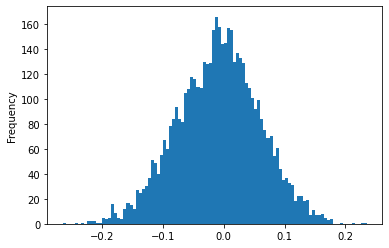

In [39]:
plt.show(north_table["north_consistency"].plot.hist(bins=100))

In [315]:
north_table = pd.read_csv("north_table1.csv") 
south_table = pd.read_csv("south_table1.csv") 
east_table = pd.read_csv("east_table1.csv") 
west_table = pd.read_csv("west_table1.csv") 

In [38]:
#OUTPUT------------------------------------------------------
north_table.to_csv('north_table1.csv', index=False) #Remove 2 for orignal
south_table.to_csv('south_table1.csv', index=False) 
east_table.to_csv('east_table1.csv', index=False) 
west_table.to_csv('west_table1.csv', index=False) 
#OUTPUT-----------------------------------------------------